## Import and old part


In [1]:
# Import general libraries
import cv2
import numpy as np

In [2]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits

img_path = 'dataset/hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

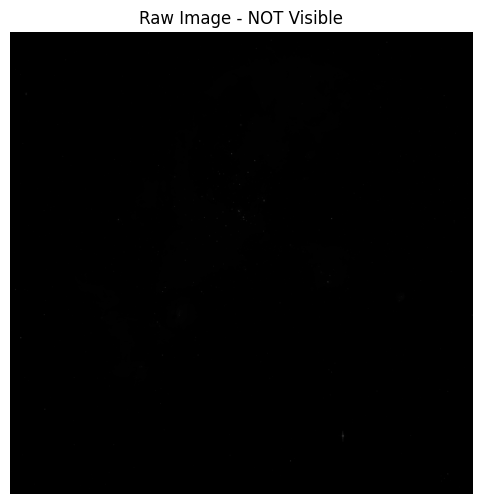

In [3]:
# Simple image plot
# Just to show that a transormation is needed to display the image
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(raw_img, cmap='gray')
plt.title('Raw Image - NOT Visible')
plt.axis('off')
plt.show()

In [4]:
# Using auto_stretch library to visualize the image
from auto_stretch import apply_stretch

stretched_img = apply_stretch(raw_img)

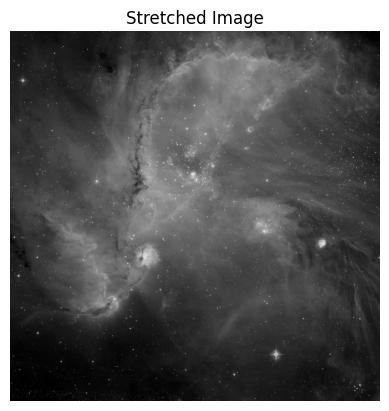

In [5]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched Image')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Arcsinh Stretched Image')

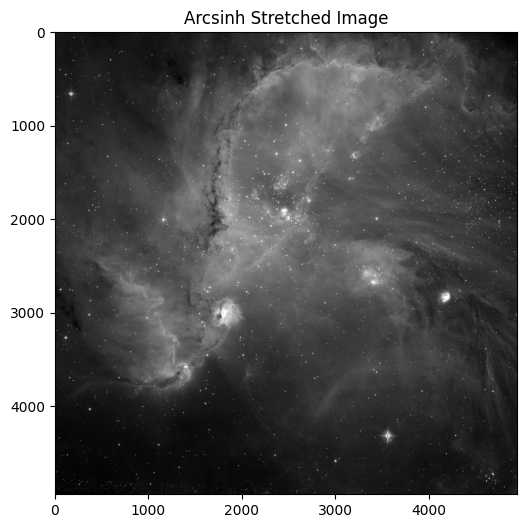

In [6]:
# arcsinh stretch

def arcsinh_stretch(image, beta, min_percent=0.1, max_percent=99.9):
    """
    Apply arcsinh stretch to the image.
    """
    # Calculate the percentiles for stretching
    p_min = np.percentile(image, min_percent)
    p_max = np.percentile(image, max_percent)

    # Normalize the image to the range [0, 1]
    norm_image = (image - p_min) / (p_max - p_min)
    norm_image = np.clip(norm_image, 0, 1)

    # Apply arcsinh stretch
    stretched_image = np.arcsinh(norm_image * beta) / np.arcsinh(beta)

    return stretched_image


stretched_img_arcsinh = arcsinh_stretch(raw_img, 10)
plt.figure(figsize=(12, 6))
plt.imshow(stretched_img_arcsinh, cmap='gray')
plt.title('Arcsinh Stretched Image')

In [8]:
from math import ceil

# Define Gaussian Kernel
# FWHM: full width at half maximum, a measure to estimate the size of stars
# compute the kernel for small/medium size stars, as bigger ones are fewer and can be treated separately
FHWM = 7 # pixels
sigma = ceil(FHWM / 2.355) # std deviation
kernel_size = (6*sigma) + 1 # rule for kernel size

print(f'Sigma: {sigma}')
print(f'Kernel size: {kernel_size}x{kernel_size}')

Sigma: 3
Kernel size: 19x19


In [9]:
gauss_img = cv2.GaussianBlur(stretched_img, (kernel_size, kernel_size), sigma)

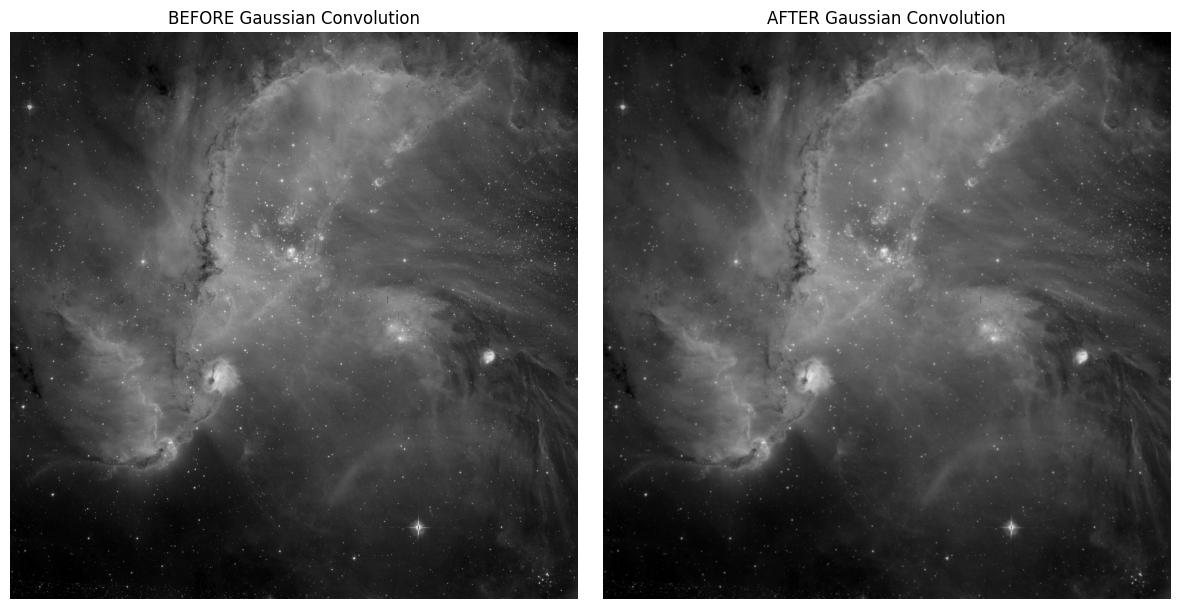

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot image BEFORE convolution against Gaussian kernel
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('BEFORE Gaussian Convolution')
axes[0].axis('off')

# Plot image AFTER convolution against Gaussian kernel
axes[1].imshow(gauss_img, cmap='gray')
axes[1].set_title('AFTER Gaussian Convolution')
axes[1].axis('off')

plt.tight_layout()
plt.show()

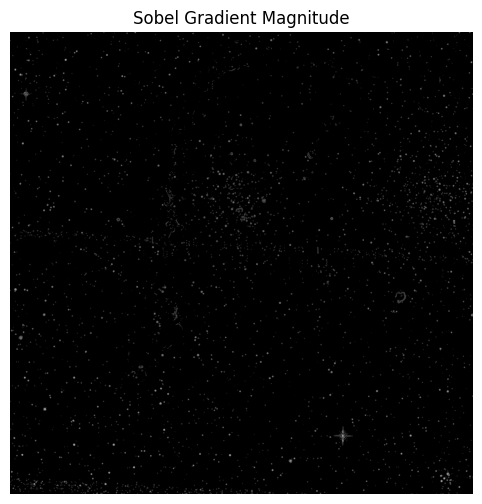

In [11]:
# Sobel gradient
sobel_x = cv2.Sobel(gauss_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gauss_img, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(sobel_x, sobel_y)
grad_mag = cv2.convertScaleAbs(grad_mag, alpha=5.0)

# Display the gradient magnitude
plt.figure(figsize=(12,6))
plt.imshow(grad_mag, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()


In [12]:
# Apply thresholding to the gradient magnitude
# Simple binary thresholding
T = 1e-4  # threshold
max_intensity = 1
_, binary_mask = cv2.threshold(grad_mag, T, max_intensity, cv2.THRESH_BINARY)


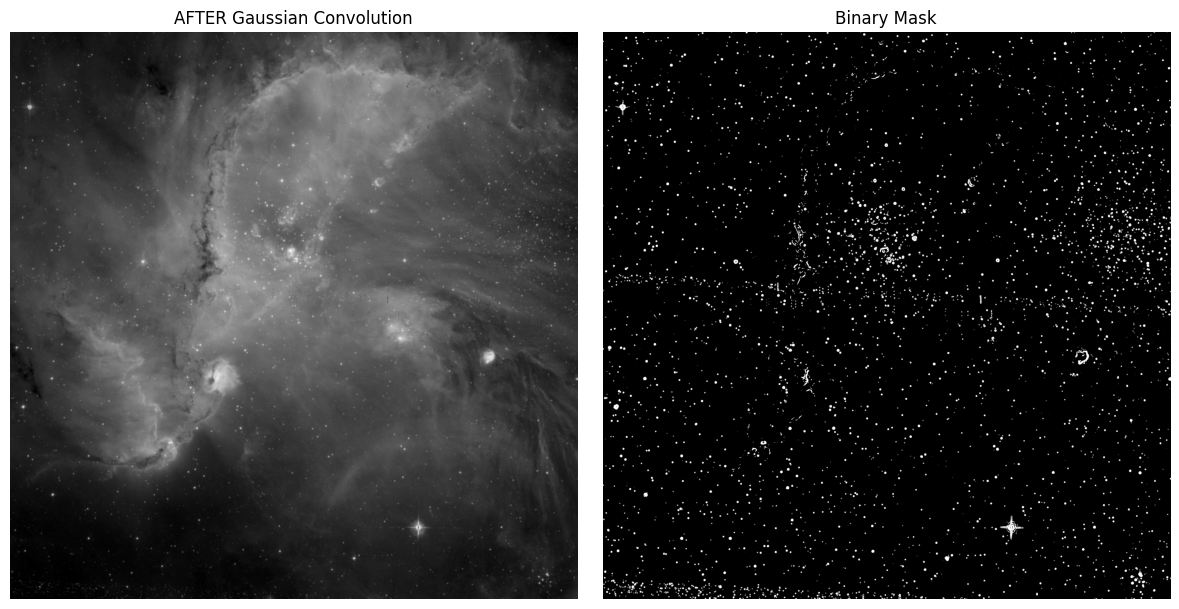

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Gaussian convolved image
axes[0].imshow(gauss_img, cmap='gray')
axes[0].set_title('AFTER Gaussian Convolution')
axes[0].axis('off')

# Plot the binary mask
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Using morphological closing to close small gaps in edges before filling
def morph_close_and_fill(mask):
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps in the edges
    closed_edges = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and fill
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(mask)
    cv2.drawContours(filled_mask, contours, -1, 255, -1)
    
    return filled_mask

final_mask = morph_close_and_fill(binary_mask)

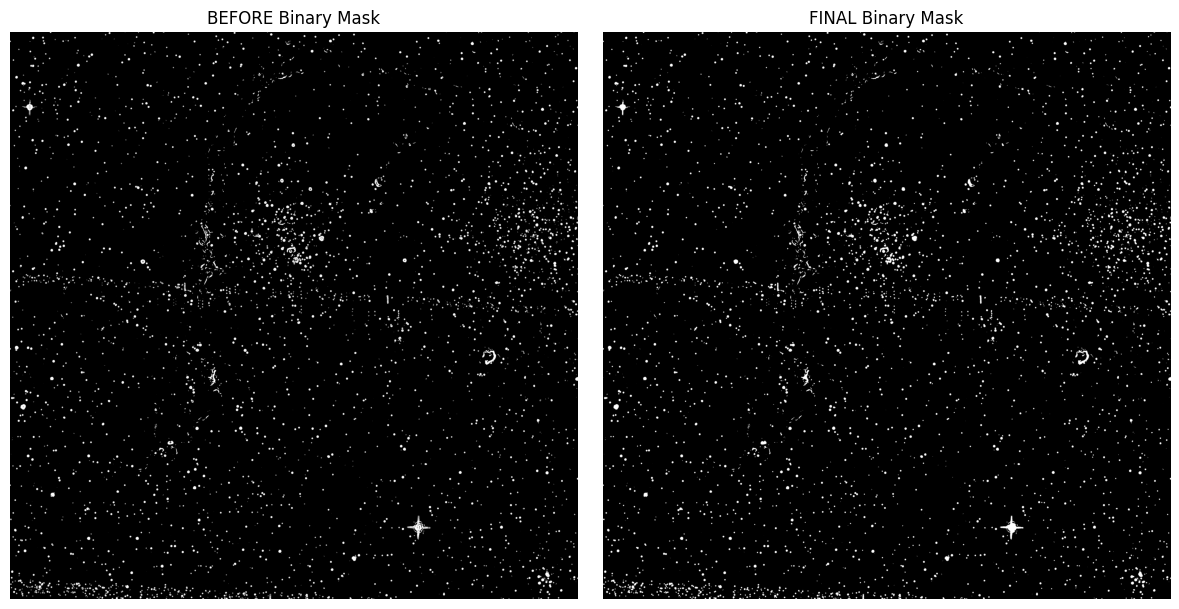

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot BEFORE binary mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('BEFORE Binary Mask')
axes[0].axis('off')

# Plot FINAL binary mask
axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title('FINAL Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
def float32_to_uint8(float_img):
    """
    Convert a float32 image to uint8 format.
    
    Parameters:
    - float_img: np.float32 array, input image
    
    Returns:
    - np.uint8 array, output image with values in range 0-255
    """
    # Check the current range of the image
    min_val = float_img.min()
    max_val = float_img.max()
    print("min: ", min_val)
    print("max: ", max_val)
    print(min_val * 255, max_val * 255)
    
    # Method 1: Simple scaling (for images already in 0-1 range)
    if 0 <= min_val and max_val <= 1:
        uint8_img = (float_img * 255).clip(0, 255).astype(np.uint8)

        print("max: ", uint8_img.max())
        print("min: ", uint8_img.min())
        
    
    # Method 2: Full normalization (for images with arbitrary ranges)
    else:
        # Normalize to 0-1 range first
        normalized_img = (float_img - min_val) / (max_val - min_val)
        # Then scale to 0-255
        uint8_img = (normalized_img * 255).clip(0, 255).astype(np.uint8)
    
    return uint8_img



In [17]:
gauss_img_final = float32_to_uint8(gauss_img)

In [18]:
# Perform inpainting for star removal
# INPAINT_TELEA is typically better for small regions like stars
# what is INPAINT_TELEA?

# gauss_img type: ?
# final_mask type: 0-255 uint8 image

inpainted_img = cv2.inpaint(gauss_img_final, final_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

KeyboardInterrupt: 

In [19]:
def diff_img(image0, image1):
    diff = cv2.absdiff(image0, image1)
    return diff

In [ ]:
stretched_img.dtype, inpainted_img.dtype

(dtype('float32'), dtype('uint8'))

In [17]:
stretched_img_uint = float32_to_uint8(stretched_img)


max:  255
min:  0


## New part

In [8]:
stretched_img_uint = float32_to_uint8(stretched_img)

# Carica immagine in scala di grigi
img = stretched_img_uint

# Applica un leggero blur per ridurre il rumore
blur = cv2.GaussianBlur(img, (3, 3), 0)

# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 50
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 3     # evita pixel singoli o rumore
params.maxArea = 100   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255

# Crea il detector
detector = cv2.SimpleBlobDetector_create(params)

# Trova i blob (stelle)
keypoints = detector.detect(blur)

# Disegna le stelle rilevate
img_con_punti = cv2.drawKeypoints(
    img, keypoints, np.array([]), (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Mostra il risultato
cv2.imwrite('./output_images/blob_keypoints.png', img_con_punti)


min:  0.0
max:  1.0
0.0 255.0
max:  255
min:  0


True

In [9]:
cv2.imwrite('./output_images/stretched.jpeg', stretched_img_uint)

True

In [10]:


# Supponi che 'img_gray' sia l'immagine usata per detect
# e 'keypoints' siano quelli trovati con SimpleBlobDetector

# Maschera iniziale: tutta a 0
mask = np.zeros(img.shape, dtype=np.uint8)

# Per ogni blob, disegna un cerchio nella maschera
for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinate centro
    r = int(kp.size / 2)                      # raggio stimato del blob
    cv2.circle(mask, (x, y), r, 255, thickness=-1)  # disegna blob nella mask (1 = dentro blob)

# (opzionale) Visualizza la maschera
# import matplotlib.pyplot as plt
# plt.imshow(mask, cmap='gray'); plt.show()
cv2.imwrite('./output_images/blob_mask.png', mask)


True

In [11]:
cv2.imwrite('./output_images/original_image.png', img)

True

In [ ]:
def use_blob_detector(name, original_image, params, smooth = 3):
    """
    Use a blob detector to find and mask stars in an image.
    
    Parameters:
    - name: str, name of the image for saving output
    - original_image: np.array, the original image
    - params: cv2.SimpleBlobDetector_Params, parameters for the blob detector
    - smooth: int, smoothing factor for Gaussian blur
    
    Returns:
    - mask: np.array, binary mask of detected stars
    """
    
    # Convert to grayscale if not already
    if len(original_image.shape) == 3:
        img_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = original_image

    # Apply Gaussian blur to reduce noise
    if smooth > 0:
        blur = cv2.GaussianBlur(img_gray, (smooth, smooth), 0)
    else:
        blur = img_gray

    # Create the blob detector with the specified parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs (stars)
    keypoints = detector.detect(blur)

    img_con_punti = cv2.drawKeypoints(
    img, keypoints, np.array([]), (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
    
    cv2.imwrite(f'./output_images/{name}_blob_keypoints.png', img_con_punti)

    # Create a mask for the detected blobs
    mask = np.zeros(img_gray.shape, dtype=np.uint8)
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
        r = int(kp.size / 2)                      # estimated radius of the blob
        cv2.circle(mask, (x, y), r, 255, thickness=-1)  # draw blob in the mask

    cv2.imwrite(f'./output_images/{name}_mask.png', mask)

    return mask

In [14]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 50
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 3     # evita pixel singoli o rumore
params.maxArea = 100   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255

mask1 = use_blob_detector('v1_small', stretched_img_uint, params, smooth=3)

In [23]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 100
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 50     # evita pixel singoli o rumore
params.maxArea = 1000   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = True
params.minInertiaRatio = 0.8  # più vicino a 1 = più simmetrico

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smooth = 3

mask2 = use_blob_detector('v2_middle', stretched_img_uint, params, smooth)

In [25]:
merged_mask = cv2.bitwise_or(mask1, mask2)
cv2.imwrite('./output_images/merged_mask.png', merged_mask)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
merged_mask = cv2.dilate(merged_mask, kernel, iterations=1)
cv2.imwrite('./output_images/merged_mask_dilated.png', merged_mask)
stretched_img_wo_stars = stretched_img_uint.copy()
stretched_img_wo_stars[merged_mask == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_m12.png', stretched_img_wo_stars)

True

In [26]:

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask1_dilated = cv2.dilate(mask1, kernel, iterations=1)
mask2_dilated = cv2.dilate(mask2, kernel, iterations=2)
merged_mask_dilated = cv2.bitwise_or(mask1_dilated, mask2_dilated)
cv2.imwrite('./output_images/merged_mask_dilated_2.png', merged_mask_dilated)

stretched_img_wo_stars = stretched_img_uint.copy()
stretched_img_wo_stars[merged_mask_dilated == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_m12.png', stretched_img_wo_stars)


True

In [27]:
# Perform inpainting to remove stars using the merged mask
inpainted_image = cv2.inpaint(stretched_img_uint, merged_mask_dilated, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Save the inpainted image
cv2.imwrite('./output_images/i1_inpainted_image.png', inpainted_image)

True